In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import random
import torch
from torch import manual_seed, nn, no_grad, optim
from torch.utils.data import DataLoader, Dataset, Subset, random_split
from torch import (cuda, float32, manual_seed, nn, no_grad, optim,
                   set_default_device, tensor)
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from statistics import mean, stdev

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"using device: {device}")

# set random seed for reproducibility
#torch.manual_seed(234);

using device: cpu


In [142]:
class HydraullicDataset(Dataset):
    def __init__(self, train_input, train_output, device='cpu'):
        self.input = torch.tensor(train_input, dtype=torch.float32).unsqueeze(1).to(device)#**2
        self.output = torch.tensor(train_output, dtype=torch.float32).to(device)

    def __len__(self):
        # Return the total number of samples in the dataset
        return self.input.shape[0]

    def __getitem__(self, idx):
        # Retrieve the input and corresponding output by index
        input_ = self.input[idx]
        output_ = self.output[idx]
        return input_, output_

def square_plot(data):
    '''Creates a square plot of the input array as seen in the assignment description, assert statements check
    whether the data is length 40.'''
    assert len(data) == 40, 'Top level array length is not 40'
    assert len(data[0]) == 40, 'Bottom level array length is not 40'
    plt.imshow(data, cmap='gray')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.colorbar()
    return plt
    
def load_data(train_input, train_output, test_input):
    '''Loads the training and the test data from the directory.
    Returns in the following order:
     1. Training input
     2. Training output
     3. Testing input'''
    input_train_data  = np.load(train_input)
    output_train_data =   np.load(train_output)
    input_test_data   =    np.load(test_input)
    return input_train_data, output_train_data, input_test_data

def disp_datarow(DataRow):
    '''Displays the square plot with the corresponding S value.'''
    plot = square_plot(DataRow[0][0])
    plot.title(f'Output S = {DataRow[1]:.3f}[m^4]')
    
def plot_losses(loss):
    plt.semilogy(loss['train'], label="train", marker=".", lw=2)
    plt.semilogy(loss['val'], label="val", marker=".", lw=2)
    plt.legend()
    plt.show()
    
def rmspe ( ypred , ytrue ):
    return (((ytrue - ypred ) / ytrue )**2).mean().sqrt()

In [111]:
in_train_data, out_train_data, in_test_data = load_data(
    'pub_input.npy', 'pub_out.npy', 'pri_in.npy'
)
train_dataset = HydraullicDataset(in_train_data,out_train_data)

### COPIED FROM LAB 8 SOLUTIONS
# split the data into training and validation sets
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_data, val_data = torch.utils.data.random_split(train_dataset, [train_size, val_size])



TypeError: 'DataLoader' object is not subscriptable

In [180]:
class HydraullicModel(nn.Module):
    
    width = 256
    
    def __init__(self, width=width):
        super(HydraullicModel, self).__init__()
        ksize = 5
        # Define the convolutional layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=ksize, stride=1, padding=ksize//2, bias=False)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=ksize, stride=1, padding=ksize//2, bias=False)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=ksize, stride=1, padding=ksize//2, bias=False)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=ksize, stride=1, padding=ksize//2, bias=False)
        self.conv5 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=ksize, stride=1, padding=ksize//2, bias=False)
        self.conv6 = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=ksize, stride=1, padding=ksize//2, bias=False)
        
        # Pooling layer
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Flatten layer
        self.flatten = nn.Flatten()
        
        # Linear Layer
        self.fc1 = nn.Linear(400,1,bias=False)
        

      
    def forward(self, x, width=width):         
        x = F.relu(self.conv1(x))  
        x = F.relu(self.conv2(x)) 
        x = self.maxpool(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.maxpool(x)
        x = F.relu(self.conv5(x))   
        x = F.relu(self.conv6(x))
        x = self.maxpool(x)
       
        x = self.flatten(x)
        x = self.fc1(x)
        
        return x

In [176]:
def train_model(train_loader,
                val_loader, 
                model,
                nepochs=1,
                lr=1e-6,
                loss_fn=rmspe,
                batch_size = 32,
                plot_result=True):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    loss_dict = {"train": [], "val": []}

    # Set up the main tqdm loop for epochs
    epochs_tqdm = tqdm(range(nepochs), desc='Training Model')
    
    # Create DataLoaders for training and validation sets
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
    
    for epoch in epochs_tqdm:
        model.train()
        epoch_loss_sum = 0

        # Train loop without tqdm for individual batches
        for x_batch, y_batch in train_loader:
            y_pred = model(x_batch)
            loss = loss_fn(y_pred, y_batch)
            epoch_loss_sum += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        avg_train_loss = epoch_loss_sum / len(train_loader)
        loss_dict["train"].append(avg_train_loss)

        # Validation loop without tqdm for individual batches
        # model.eval()
        val_loss_sum = 0
        with torch.no_grad():
            for x_val, y_val in val_loader:
                y_pred = model(x_val)
                loss = loss_fn(y_pred, y_val)
                val_loss_sum += loss.item()

        avg_val_loss = val_loss_sum / len(val_loader)
        loss_dict["val"].append(avg_val_loss)
        
        # Update tqdm bar only once per epoch with the average losses
        epochs_tqdm.set_description(f'Epoch {epoch+1}/{nepochs} - Train Loss: {avg_train_loss:.4f} - Val Loss: {avg_val_loss:.4f}')
        
        if epoch > 10 and mean(loss_dict['val'][-3:]) > mean(loss_dict['val'][-10:-7]):
            break
        
    if plot_result:
        plot_losses(loss_dict)
            
            
    return model, loss_dict


In [186]:
# Define model arguments
max_epochs = 500
lr = 1e-6
loss_fn = rmspe

Epoch 430/500 - Train Loss: 0.9069 - Val Loss: 0.8981:  86%|████████▌ | 429/500 [10:13<01:41,  1.43s/it]


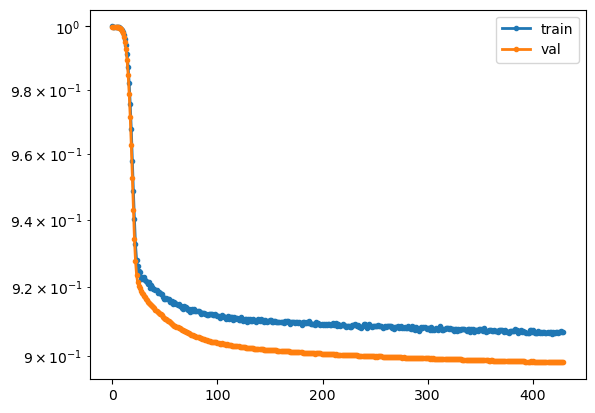

In [187]:
model = HydraullicModel().to(device)

model, loss_dict = train_model(
    train_loader, 
    val_loader,
    model,
    nepochs=max_epochs,
    lr=lr,
    loss_fn=loss_fn,
    batch_size=2**4,
    plot_result=True
)


In [157]:
y_pred = model(torch.tensor(in_test_data, dtype=torch.float32).unsqueeze(1).to(device))
print(y_pred)

Linear(in_features=64, out_features=1, bias=False)


In [141]:
### GENERATE OUTPUT CSV
y_pred = model(torch.tensor(in_test_data, dtype=torch.float32).unsqueeze(1).to(device))
y_pred_kag = y_pred.detach().numpy()
pd.DataFrame(y_pred_kag).to_csv("kaggle_submission.csv", header=["Solution"], index_label="Id")
